In [1]:
import numpy as np
import rasterio
from rasterio.windows import Window

import cv2 
import geopandas as gpd

from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import cascaded_union
from collections import defaultdict

from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

In [2]:
# creating polygons from pixel masks
# from https://www.kaggle.com/lopuhin/full-pipeline-demo-poly-pixels-ml-poly

def mask_to_polygons(mask, epsilon=10, min_area=50.):
    # first, find contours with cv2: it's much faster than shapely
    image, contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
#     epsi = lambda x: epsilon*cv2.arcLength(x,True)
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons

In [3]:
INPUT = Path('/media/splash/00F2D259F2D25310/Data/final/outputs')
COG_URL = Path('/media/splash/00F2D259F2D25310/Data/final/arid.tif')

## If needed, reproject to EPSG:4326

In [4]:
src_tif = 'arid1x_merged.tif'
dst_tif = 'arid1x_merged_reproj.tif'

In [5]:
raster = rasterio.open(INPUT/src_tif,'r')
raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 6431,
 'height': 6503,
 'count': 3,
 'crs': CRS.from_epsg(3785),
 'transform': Affine(0.14931428515517545, 0.0, 8135024.072190155,
        0.0, -0.14931402813080957, 3982066.4113659593)}

In [6]:
# https://rasterio.readthedocs.io/en/latest/topics/reproject.html

from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:4326'

with rasterio.open(INPUT/src_tif) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height,
        'compress': 'JPEG',
        'tiled': True, 
        'blockxsize': 256, 
        'blockysize': 256
    })

    with rasterio.open(INPUT/dst_tif, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest,
            )

or with gdalwarp on CLI:

In [ ]:
!gdalwarp -co compress=JPEG -co PHOTOMETRIC=YCBCR -co TILED=YES -co "BLOCKXSIZE=256" -co "BLOCKYSIZE=256" -s_srs EPSG:32737 -t_srs EPSG:4326 {INPUT}/{src_tif} {INPUT}/{dst_tif}   

## Open and Read Windows

In [7]:
dst_tif = 'arid1x_merged_reproj.tif'

In [8]:
raster = rasterio.open(INPUT/dst_tif,'r')
data = raster.read()

In [9]:
raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 6997,
 'height': 5890,
 'count': 3,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(1.2328306174800615e-06, 0.0, 73.07816460728642,
        0.0, -1.2328306174800615e-06, 33.651230626615664)}

In [10]:
raster.block_shapes

[(256, 256), (256, 256), (256, 256)]

In [11]:
def pad_window(window, pad):
    col_off, row_off, width, height = window.flatten()
    return Window(col_off-pad//2, row_off-pad//2,width+pad,height+pad)

In [12]:
# padded windowed reads with blocks and rasterio: https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html

pad = 64
windows = []
for ji, window in raster.block_windows(1):
    assert len(set(raster.block_shapes)) == 1
    window_padded = pad_window(window, pad)
    windows.append((ji, window_padded))

In [13]:
len(windows)

672

In [14]:
windows[150:160]

[((5, 10), Window(col_off=2528, row_off=1248, width=320, height=320)),
 ((5, 11), Window(col_off=2784, row_off=1248, width=320, height=320)),
 ((5, 12), Window(col_off=3040, row_off=1248, width=320, height=320)),
 ((5, 13), Window(col_off=3296, row_off=1248, width=320, height=320)),
 ((5, 14), Window(col_off=3552, row_off=1248, width=320, height=320)),
 ((5, 15), Window(col_off=3808, row_off=1248, width=320, height=320)),
 ((5, 16), Window(col_off=4064, row_off=1248, width=320, height=320)),
 ((5, 17), Window(col_off=4320, row_off=1248, width=320, height=320)),
 ((5, 18), Window(col_off=4576, row_off=1248, width=320, height=320)),
 ((5, 19), Window(col_off=4832, row_off=1248, width=320, height=320))]

In [15]:
def poly2coords(poly_mask, transform):
    geo_coords = [(coord[0],coord[1])*transform for coord in poly[0].exterior.coords for poly in poly_mask]
    return Polygon(geo_coords)

In [16]:
mask_thres = 0.7
epsilon = 10
min_area = 100.
erode = 5
dilate = 7

polys = []

for window in tqdm(windows):
    win_tnfm = rasterio.windows.transform(window[1], raster.meta['transform'])
    win_img = raster.read(window=window[1])[0,:,:]

    mask = win_img > (mask_thres*255)
    # erode and dilate
    mask = cv2.erode(mask.astype('uint8'), np.ones((erode,erode),np.uint8), iterations=1)
    mask = cv2.dilate(mask.astype('uint8'), np.ones((dilate,dilate),np.uint8), iterations=1)

    # label via connected components
    _, instances = cv2.connectedComponents(mask.astype('uint8'))

    # make polys from instances
    uniques = list(np.unique(instances))
    for b in uniques[1:]:
        poly = mask_to_polygons(instances==b,epsilon, min_area)
        try: 
            if poly.type == 'MultiPolygon': 
                geo_coords = poly2coords(poly, win_tnfm)
                polys.append(geo_coords)
            #else: print('not a MultiPolygon')
        except Exception as exc: print(f"{exc}: {window}")

100%|██████████| 672/672 [00:01<00:00, 662.94it/s]


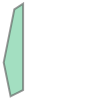

In [17]:
polys[5]

In [18]:
len(polys)

357

In [19]:
# dedupe windowed polys
merged_poly = gpd.GeoDataFrame()
merged_poly['geometry'] = gpd.GeoSeries(cascaded_union(polys))

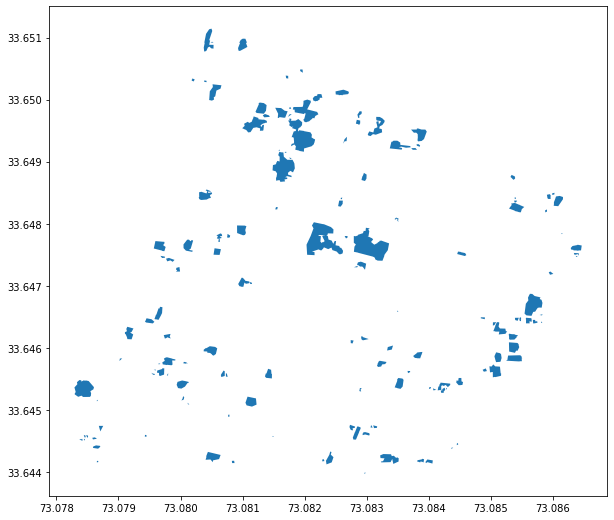

In [20]:
merged_poly['geometry'].plot(figsize=(10,10))

In [21]:
# https://gis.stackexchange.com/questions/271733/geopandas-dissolve-overlapping-polygons
# https://nbviewer.jupyter.org/gist/rutgerhofste/6e7c6569616c2550568b9ce9cb4716a3

def explode(gdf):
    """    
    Will explode the geodataframe's muti-part geometries into single 
    geometries. Each row containing a multi-part geometry will be split into
    multiple rows with single geometries, thereby increasing the vertical size
    of the geodataframe. The index of the input geodataframe is no longer
    unique and is replaced with a multi-index. 

    The output geodataframe has an index based on two columns (multi-index) 
    i.e. 'level_0' (index of input geodataframe) and 'level_1' which is a new
    zero-based index for each single part geometry per multi-part geometry
    
    Args:
        gdf (gpd.GeoDataFrame) : input geodataframe with multi-geometries
        
    Returns:
        gdf (gpd.GeoDataFrame) : exploded geodataframe with each single 
                                 geometry as a separate entry in the 
                                 geodataframe. The GeoDataFrame has a multi-
                                 index set to columns level_0 and level_1
        
    """
    gs = gdf.explode()
    gdf2 = gs.reset_index().rename(columns={0: 'geometry'})
    gdf_out = gdf2.merge(gdf.drop('geometry', axis=1), left_on='level_0', right_index=True)
    gdf_out = gdf_out.set_index(['level_0', 'level_1']).set_geometry('geometry')
    gdf_out.crs = gdf.crs
    return gdf_out

In [22]:
gdf_out = explode(merged_poly)
gdf_out = gdf_out.reset_index()

In [23]:
gdf_out.tail(10)

,level_0,level_1,geometry
137,0,137,"POLYGON ((73.08167443854619 33.64971041125181,..."
138,0,138,"POLYGON ((73.08048286196323 33.64842963545275,..."
139,0,139,"POLYGON ((73.08590979531148 33.64842425733259,..."
140,0,140,"POLYGON ((73.08602513530349 33.64849867396733,..."
141,0,141,"POLYGON ((73.08637402636823 33.64746556190988,..."
142,0,142,"POLYGON ((73.07970317989704 33.64744830228123,..."
143,0,143,"POLYGON ((73.08325249924476 33.64740392037901,..."
144,0,144,"POLYGON ((73.07990289845706 33.6474174815158, ..."
145,0,145,"POLYGON ((73.08633580861908 33.64752966910199,..."
146,0,146,"POLYGON ((73.08451491779707 33.647542315558, 7..."


In [24]:
# fill holes
gdf_out.geometry = gdf_out.geometry.apply(lambda x: Polygon([coords for coords in x.exterior.coords]))

In [25]:
gdf_out.drop(columns=['level_0','level_1'], inplace=True)

In [26]:
gdf_out.head(10)

,geometry
0,"POLYGON ((73.08295538706595 33.6439754184318, ..."
1,"POLYGON ((73.07865527387217 33.6441800683143, ..."
2,"POLYGON ((73.08394535005179 33.64416157585504,..."
3,"POLYGON ((73.08381836849819 33.64418993095924,..."
4,"POLYGON ((73.08082628858956 33.6441800683143, ..."
5,"POLYGON ((73.08228349437942 33.64417143849997,..."
6,"POLYGON ((73.07858870101883 33.64438841668865,..."
7,"POLYGON ((73.08445327626619 33.64446361935632,..."
8,"POLYGON ((73.08436204680049 33.64436992422939,..."
9,"POLYGON ((73.0832330775162 33.64415745609443, ..."


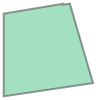

In [27]:
gdf_out.iloc[5].geometry

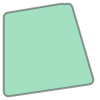

In [28]:
gdf_out.iloc[5].geometry.buffer(0.000002, cap_style=1, join_style=1)

In [29]:
# buffer polys
gdf_out['geometry_buffered'] = gdf_out.geometry.buffer(0.000002, cap_style=1, join_style=1)

In [30]:
~raster.meta['transform']

Affine(811141.4381028487, 0.0, -59276727.53347101,
       0.0, -811141.4381028487, 27295907.604403656)

In [31]:
gdf_out['coords_pixel'] = gdf_out.geometry_buffered.apply(lambda x: Polygon([np.round(coords*~raster.meta['transform']) for coords in x.exterior.coords]))

In [32]:
gdf_out['coords_geo_rounded'] = gdf_out.geometry_buffered.apply(lambda x: Polygon([np.round(coords,6) for coords in x.exterior.coords]))

In [33]:
gdf_out.head()

,geometry,geometry_buffered,coords_pixel,coords_geo_rounded
0,"POLYGON ((73.08295538706595 33.6439754184318, ...","POLYGON ((73.08295550451 33.64397342188305, 73...","POLYGON ((3886 5887, 3886 5887, 3886 5887, 388...","POLYGON ((73.082956 33.643973, 73.082955 33.64..."
1,"POLYGON ((73.07865527387217 33.6441800683143, ...","POLYGON ((73.07865335514117 33.64418063264694,...","POLYGON ((396 5719, 396 5718, 397 5718, 397 57...","POLYGON ((73.078653 33.644181, 73.078653 33.64..."
2,"POLYGON ((73.08394535005179 33.64416157585504,...","POLYGON ((73.08394356119742 33.64416068142785,...","POLYGON ((4688 5735, 4687 5735, 4687 5734, 468...","POLYGON ((73.083944 33.644161, 73.083943 33.64..."
3,"POLYGON ((73.08381836849819 33.64418993095924,...","POLYGON ((73.08381655613191 33.64419077673016,...","POLYGON ((4585 5710, 4585 5710, 4585 5710, 458...","POLYGON ((73.083817 33.644191, 73.083817 33.64..."
4,"POLYGON ((73.08082628858956 33.6441800683143, ...","POLYGON ((73.0808243073473 33.64417979503951, ...","POLYGON ((2157 5719, 2157 5719, 2157 5719, 215...","POLYGON ((73.08082400000001 33.64418, 73.08082..."


In [34]:
gdf_out.geometry = gdf_out.geometry_buffered

In [35]:
gdf_out.geometry.to_file(f'/media/splash/00F2D259F2D25310/Data/final/outputs/arid.geojson', driver='GeoJSON')

# Crop detected building images for further classifier

In [ ]:
cog_rst = rasterio.open(COG_URL,'r')

In [ ]:
cog_rst.meta

In [ ]:
df = gpd.read_file(f'/media/splash/00F2D259F2D25310/Data/final/outputs/arid.geojson')
df.tail()

In [ ]:
cog_rst.meta['crs']['init']

In [ ]:
from pyproj import Proj, transform

condition = 'test'
grid_num = '042'
CLASSIFY = Path('/media/splash/00F2D259F2D25310/Data/final')
CLASSIFY.mkdir(exist_ok=True)
(CLASSIFY/f'{condition}_{grid_num}').mkdir(exist_ok=True)

for i,row in tqdm(df[(df['geometry'].type=='Polygon')].iterrows()):
    
    poly = row['geometry'].buffer(0.00001) # padding around detection to crop
#     print(poly.bounds)

    inProj = Proj(init='epsg:4326') 
    outProj = Proj(init=cog_rst.meta['crs']['init']) # convert to cog crs
    
    # convert from geocoords to display window
    minx, miny = transform(inProj,outProj,*poly.bounds[:2])
    maxx, maxy = transform(inProj,outProj,*poly.bounds[2:])
    ul = cog_rst.index(minx, miny)
    lr = cog_rst.index(maxx, maxy)
    disp_minx, disp_maxx, disp_miny, disp_maxy = lr[0], (max(ul[0],0)+1), max(ul[1],0), (lr[1]+1)

    if disp_maxx-disp_minx <= 150: disp_maxx += 25; disp_minx-=25; 
    if disp_maxy-disp_miny <= 150: disp_maxy += 25; disp_miny-=25;

    window = (max(disp_minx,0), disp_maxx), (max(disp_miny,0), disp_maxy)
    data = cog_rst.read(window=window)
    
    pk = str(row.id).zfill(5)
    tile_bgr = cv2.cvtColor(np.rollaxis(data,0,3), cv2.COLOR_RGB2BGR)
    cv2.imwrite(f"{str(CLASSIFY)}/{condition}_{grid_num}/{grid_num}_{pk}_{condition}.jpg", tile_bgr)
